# 7.4 합성곱/풀링 계층 구현하기
## 7.4.1 4차원 배열

In [1]:
import numpy as np

In [2]:
x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

* 높이 28, 너비 28, 채널 1개인 데이터가 10개

In [3]:
#10개 중 첫 번째 데이터에 접근하려면 단순히 x[0]
x[0].shape
x[1].shape

(1, 28, 28)

In [4]:
#첫 번째 데이터의 첫 채널의 공간 데이터에 접근
x[0,0]

array([[0.12033843, 0.28919283, 0.37677769, 0.53403179, 0.27682319,
        0.92986235, 0.45280887, 0.59880485, 0.37717265, 0.08944388,
        0.23331252, 0.8953105 , 0.40133403, 0.84952056, 0.04897727,
        0.8282982 , 0.97047449, 0.92421836, 0.84415563, 0.98114437,
        0.34056012, 0.52226557, 0.75273761, 0.49064388, 0.29830609,
        0.67498261, 0.04204519, 0.07455291],
       [0.59148914, 0.13274061, 0.79931373, 0.57265647, 0.95643939,
        0.91309698, 0.90525631, 0.71499649, 0.29335641, 0.3846483 ,
        0.35634831, 0.43896115, 0.92100699, 0.03897701, 0.02141674,
        0.03949298, 0.03878334, 0.57253885, 0.89886385, 0.27877892,
        0.7044477 , 0.46871861, 0.5039713 , 0.90659491, 0.12310035,
        0.70019986, 0.43823425, 0.70552543],
       [0.67964373, 0.16782104, 0.87142695, 0.52901919, 0.45498174,
        0.6760154 , 0.69039236, 0.09832803, 0.84457547, 0.93591812,
        0.75311623, 0.40094423, 0.19163259, 0.37298266, 0.12007193,
        0.81223551, 0.7398

## 7.4.2 im2col로 데이터 전개하기
#### im2col은 입력 데이터를 필터링(가중치 계산)하기 좋게 전개하는(펼치는) 함수
#### 3차원 입력 데이터에 im2col을 적용하면 2차원 행렬로 바뀜(4차원->2차원)
<img src="refimg/7-18.png">

### 합성 계층의 구현 흐름
<img src="refimg/7-19.png">


In [6]:
#im2col 함수의 구현 및 인터페이스 설명
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant') #합성곱에서 padding 구현
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

* input_data - (데이터 수, 채널 수, 높이, 너비)의 4차원 배열로 이뤄진 입력 데이터
* filter_h - 필터의 높이
* filter_w - 필터의 너비
* stride - 스트라이드
* pad - 패딩


이 im2col은 '필터 크기', '스트라이드', '패딩'을 고려하여 입력 데이터를 2차원 배열로 전개

In [7]:
x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


## 7.4.3 합성곱 계층 구현하기
[심화 과정]("https://www.slideshare.net/leeseungeun/cnn-vgg-72164295")

합성곱 계층을 구현. forward와 backward 메서드를 활용. 
역전파를 구현하기 위해 im2col을 역전해 col2im을 구현

In [9]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [10]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        #필터(가중치)는 (FN, C, FH, FW)의 4차원 형상
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        
        #이 부분 중요-> 입력 데이터를 im2col로 전개하고 필터도 reshape를 활용해 2차원 배열로 전개
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T #필터 전개
        out = np.dot(col, col_W) + self.b #행렬 곱
        
        #-1, transpose -> 출력 데이터를 적절한 형상으로 바꿔줌(p247)
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout): #2차원 -> 4차원
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        
        #편향의 첫 번째 축의 합-합 노드이므로 별도 수식 없이 그대로
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout) #가중치 전치 행렬과의 행렬곱
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

<img src="refimg/5-27.png">

## 7.4.4 풀링 계층 구현하기
### 채널 쪽이 독립적이라는 점이 합성곱 계층 때와 다름
#### 입력 데이터를 전개한 후, 전개한 행렬에서 행 별 최댓값을 구하고 적절한 형상으로 성형
<img src="refimg/7-22.png">

In [11]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        #전개(1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        #최댓값(2)
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1) #2차원 배열, 행렬이라면 axis=0은 열 방향, 1은 행 방향
        #성형(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    #5.5.1 ReLU의 max 역전파 참고
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

# 7.5 CNN 구현하기
simpleConvNet 클래스 
초기화 때 받는 인수
* input_dim – 입력 데이터(채널 수, 높이, 너비)의 차원
* conv_param – 합성곱 계층의 하이퍼파라미터(딕셔너리), 딕셔너리의 키는 다음과 같다.
  - filter_num – 필터 수
  - filter_size – 필터 크기
  - stride – 스트라이드
  - pad – 패딩
* hidden_size – 은닉층(완전연결)의 뉴런 수
* output_size – 출력층(완전연결)의 뉴런 수
* weight_init_std – 초기화 때의 가중치 표준편차


합성곱 계층의 하이퍼 파라미터는 딕셔너리 형태로 주어지며, {‘filter_num’:30, ‘filter_size’:5, ‘pad’:0, ‘stride’:1}처럼 저장된다는 뜻.


In [14]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        #초기화 인수로 주어진 합성곱 계층의 하이퍼 파라미터를 딕셔너리에서 꺼냄
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        #합성곱 계층의 출력 크기를 계산
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화 - 매개 변수들을 params 딕셔너리에 저장
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성 - 순서가 있는 딕셔너리인 layers에 계층들 차례로 추가
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        #별도 변수에 저장
        self.last_layer = SoftmaxWithLoss()

    #초기화 때 layers에 추가한 계층을 맨 앞에서부터 
    #차례로 forward 메서드를 호출하여 그 결과를 다음 계층에 전달
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    #predict 메서드의 결과를 인수로 마지막 층의 forward 메서드를 호출
    #즉, 첫 계층부터 마지막 계층까지 forward를 처리함
    def loss(self, x, t):
        """손실 함수를 구한다.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    #매개변수의 기울기 구하기 - 순전파와 역전파를 반복
    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.2995086500161093
=== epoch:1, train acc:0.198, test acc:0.199 ===
train loss:2.299309931107939
train loss:2.293338804427441
train loss:2.287625785286728
train loss:2.2818144246885184
train loss:2.269634842833055
train loss:2.254377864588165
train loss:2.226564821985859
train loss:2.2316145422583786
train loss:2.1855816356859
train loss:2.1584000361000473
train loss:2.0862288803544957
train loss:2.059547388936664
train loss:2.010987297135968
train loss:1.9249063315018093
train loss:1.9183326075620757
train loss:1.8149587793028312
train loss:1.83834962630422
train loss:1.732641302545534
train loss:1.5414873734999568
train loss:1.4715661622789111
train loss:1.5532683413043678
train loss:1.4858979225854387
train loss:1.1535773907581754
train loss:1.2591809795126254
train loss:1.1193526286338615
train loss:1.080071590911592
train loss:1.0257170770216169
train loss:0.9630280280512636
train loss:0.8695949125921494
train loss:0.8564591932700933
train loss:0.8944338063660446
train 

train loss:0.12102166411282442
train loss:0.22956785130243207
train loss:0.2866611760737355
train loss:0.15937152071805305
train loss:0.20208747754680356
train loss:0.4107326189288824
train loss:0.14126361226801826
train loss:0.165670959869273
train loss:0.10417358913809775
train loss:0.3133895945918418
train loss:0.33415087863227455
train loss:0.1875811711713524
train loss:0.17016436469596932
train loss:0.18155991794748785
train loss:0.3134717308954751
train loss:0.16372452324726924
train loss:0.12041949441419612
train loss:0.23499289546575658
train loss:0.07557453790989259
train loss:0.23820903692081097
train loss:0.23129361618210198
train loss:0.16625906998119894
train loss:0.2606536187856524
train loss:0.15593979618106035
train loss:0.09211725949113408
train loss:0.1926515975066704
train loss:0.12003242650615713
train loss:0.1339175402981548
train loss:0.13126725824514512
train loss:0.20047131196081047
train loss:0.09022234333916336
train loss:0.2226482593276533
train loss:0.122867

train loss:0.07911832398077857
train loss:0.14010199303923487
train loss:0.0594556415628617
train loss:0.09463775146651181
train loss:0.10730566992854955
train loss:0.05381357820990749
train loss:0.11178752467000994
train loss:0.07248459401990733
train loss:0.1492186885141472
train loss:0.07479063125151414
train loss:0.13916994703976188
train loss:0.09310152721109471
train loss:0.07743532299936326
train loss:0.06960469696405844
train loss:0.11079314960408829
train loss:0.08662246198390727
train loss:0.08917281128111228
train loss:0.06054023686854679
train loss:0.06550083783975942
train loss:0.08941758483519456
train loss:0.050299100896318914
train loss:0.10016522854479976
train loss:0.11640078550284672
train loss:0.09422995323057133
train loss:0.04973081251453307
train loss:0.09866812935690257
train loss:0.05775183013512783
train loss:0.04413124148623489
train loss:0.06841893334459219
train loss:0.05396722375618914
train loss:0.058144183678582324
train loss:0.08006353267350338
=== epoc

train loss:0.0446713830343935
train loss:0.07032572794212691
train loss:0.031328098505445164
train loss:0.01971700897449191
train loss:0.03813537468018899
train loss:0.01914522029404815
train loss:0.04194851727882615
train loss:0.03403015690502777
train loss:0.043919203307425055
train loss:0.02012073038799389
train loss:0.02945954475415375
train loss:0.06606325631544994
train loss:0.01126113671458113
train loss:0.017127432789823746
train loss:0.06757848679660769
train loss:0.008721600955374458
train loss:0.04044146583727091
train loss:0.022756704486367935
train loss:0.03558869591687394
train loss:0.04996838132589283
train loss:0.021780102444541993
train loss:0.02130062127522086
train loss:0.044337377685519416
train loss:0.032000892198268745
train loss:0.014223045637961045
train loss:0.022814300101207476
=== epoch:17, train acc:0.986, test acc:0.957 ===
train loss:0.07585156694047321
train loss:0.052910802221372316
train loss:0.01331992675321498
train loss:0.019898869913831826
train los

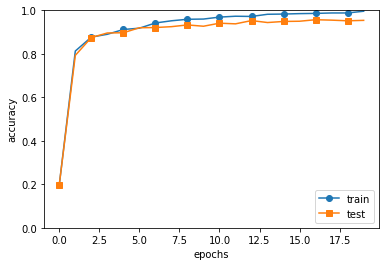

In [16]:
#학습 수행
#MNIST 데이터 셋 학습하기
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 학습 수행
#### 합성곱 계층과 풀링 계층은 이미지 인식에 필수적인 모듈
#### 이미지라는 공간적인 형상에 담긴 특징을 CNN이 잘 파악하여 손글씨 숫자 인식에서 높은 정확도를 달성할 수 있음


# 7.6 CNN 시각화 하기
## 7.6.1 1번째 층의 가중치 시각화하기
MNIST 데이터셋으로 간단한 CNN 학습 수행. 이때 1번째 층의 합성곱 계층의 가중치는 그 형상이 (30, 1, 5, 5)였음(필터 30개, 채널 1개, 5X5 크기). 


필터의 크기가 5X5이고 채널이 1개라는 것은 이 필터를 1채널의 회색조 이미지로 시각화 할 수 있다는 뜻.
합성곱 계층(1층째) 필터를 이미지로(학습 전과 후의 가중치를 비교)

학습 후에는 가중치가 규칙성을 띔. 이때, 에지(색상에 바뀐 경계선)와 블롭(국소적으로 덩어리진 영역) 등의 원시적인 정보를 추출할 수 있음

<img src="refimg/7-25.png">

## 7.6.2 층 깊이에 따른 추출 정보 변화
합성곱 계층을 여러 겹 쌓을수록 사물의 ‘의미’를 이해하도록 변화

<img src="refimg/7-26.png">


<img src="refimg/conv.png">

# 7.7 대표적인 CNN
## LeNet VS AlexNet
### 합성곱 계층과 풀링 계층(정확히는 단순히 ‘원소를 줄이기’만 하는 서브샘플링 계층)을 반복하고, 마지막으로 완전연결 계층을 거치면서 결과를 출력
## LeNet
<img src="refimg/lenet.png">

## AlexNet - 합성곱 계층과 풀링 계층을 거듭하며 마지막으로 완전연결 계층을 거쳐 결과를 출력
<img src="refimg/alexnet.png">

#### 활성화 함수: 시그모이드 vs ReLU
#### 서브샘플링 -> 최대 풀링
#### 국소적 정규화
#### 드롭아웃